In [1]:
import torch
import gpytorch
import GPy
import math
from SC_IPFP.torch.utils import NN, log_kde_pdf_per_point, silvermans_rule
from SC_IPFP.torch.sde_solvers_time import solve_sde_RK


from tqdm.notebook import tqdm

from torch import nn

import itertools
from functools import partial
# np = jax.numpy
import matplotlib.pyplot as plt

In [2]:
def solve_sde_RK(alfa=None, beta=None, X0=None, dt=1.0, N=100, t0=0.0,
                theta=None, noise=False, forwards=True):
    """
            Euler Mayurama method
    Syntax:
    ----------
    solve_sde(alfa=None, beta=None, X0=None, dt=None, N=100, t0=0, DW=None)
    Parameters:
    ----------
        alfa  : a  function with two arguments, the X state and the time
                defines the differential equation.
        beta  : a  function with two arguments, the X state and the time
                defines the stochastic part of the SDE.
        X0    : Initial conditions of the SDE. Mandatory for SDEs
                with variables > 1 (default: gaussian np.random)
        dt    : The timestep of the solution
                (default: 1)
        N     : The number of timesteps (defines the length of the timeseries)
                (default: 100)
        t0    : The initial time of the solution
                (default: 0)
    
    """
    
#     print(X0)
       
    if alfa is None or beta is None:
        raise ValueError("Error: SDE not defined.")

    n, d, *_ = X0.shape
    
    T = torch.tensor(dt * N).cuda()
    
    DWs  = torch.empty((n, N-1, d)).normal_(mean=0, std=1).cuda() * math.sqrt(dt)
    
    
    Y, ti = torch.zeros((n, N, d + 1)).double().cuda(), torch.arange(N).double().cuda()*dt + t0
    t0rep =  (
        t0 * torch.ones((X0.shape[0], 1)).double().cuda() if forwards
        else (T-t0) * torch.ones((X0.shape[0], 1)).double().cuda()
    )
#     Y[:, 0, :] =  torch.cat((X0, t0rep), axis=1 )
    Y = torch.cat((X0, t0rep), axis=1 )[:, None, :]

    N = int(N)
    
    T = dt * N
        
    for n in range(N-1):
        t = ti[n]
        a, DW_n = alfa(Y[:,n, :]),  DWs[:,n,:]
        newY = (  
            Y[:,n, :-1] + a * dt + beta * DW_n
        )
        
        trep = (
            t.repeat(newY.shape[0]).reshape(-1,1) if forwards
            else T - t.repeat(newY.shape[0]).reshape(-1,1)
        )
        
        tocat = torch.cat((newY, trep), dim=1)[:, None, :]
        Y = torch.cat((Y,tocat) , dim=1)
    if torch.isnan(Y).any() or torch.isinf(Y).any(): import pdb; pdb.set_trace()
#     import pdb; pdb.set_trace()
    return ti, Y

In [3]:
def plot_trajectories_both(Xts,t , Xts_, t_):

    fn = 14
    fig, axs = plt.subplots(2,1,  sharey=False, figsize=(15,10))
    axs[1].set_xlabel("$t$", fontsize=fn)
    axs[1].set_ylabel("$x(t)$", fontsize=fn)
    axs[0].set_ylabel("$x(t)$", fontsize=fn)

    tt = axs[1].get_xticks()
    axs[1].set_xticks(tt.flatten() )
    axs[1].set_xticklabels(list(map (lambda x: '{0:.2f}'.format((x)), tt))[::-1])
    
    n =  Xts.shape[0]
    for i in range(n):
        label = "$\mathbb{Q}$: Forward process" if i == 0 else None
        axs[0].plot(t.cpu().flatten(), Xts[i,:,:-1].detach().cpu().numpy().flatten(), 'b', alpha=0.3,  label=label)

    n =  Xts_.shape[0]
    for i in range(n):
        label = "$\mathbb{P}$: Reverse process" if i == 0 else None
        axs[1].plot(t_.cpu().flatten(), Xts_[i,:, :-1].detach().cpu().numpy().flatten(), 'r', alpha=0.3, label=label)

    axs[1].legend(fontsize=fn)
    axs[0].legend(fontsize=fn)

    plt.show() 

 /anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:34: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 /anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning:To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


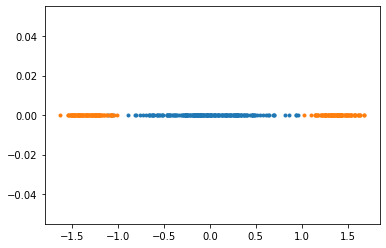

In [4]:
import numpy.random as npr
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
torch.manual_seed(0)


n = 200
n2 = int(0.5 * n)

Z = 1 * torch.tensor(1 * np.random.randn(n2).reshape(n2, 1))  + 10
X  = 1 * torch.tensor(1 * np.random.randn(n2).reshape(n2, 1))  - 10
Y  =  3.0 *torch.tensor(1 * np.random.randn(n).reshape(n, 1)) - 0

X = torch.cat((X,Z), dim =0 )

s = torch.cat((X,Y), dim=0).std()
m = torch.cat((X,Y), dim=0).mean()

X = (X - m) / s
Y = (Y -  m) / s

X1, X2 = Y, X


plt.plot(X1.flatten(), [0] * n, '.')
plt.plot(X2.flatten(), [0] * n, '.')


with torch.cuda.device(0):

    X1 = torch.tensor(X1).cuda()
    X2 = torch.tensor(X2).cuda()

In [5]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def plot_trajectories_( Xts, t):

    fn = 14
    fig, axs = plt.subplots(1,1,  sharey=False, figsize=(15,10))
    axs.set_ylabel("$x(t)$", fontsize=fn)



    for i in range(n):
        label = "$\mathbb{Q}$: Forward process" if i == 0 else None
        axs.plot(t.cpu().flatten(), Xts[i,:,:-1].detach().cpu().numpy().flatten(), 'b', alpha=0.3,  label=label)

    plt.show()    
    

def plot_trajectories_2( Xts, t):

    fn = 14
    fig, axs = plt.subplots(1,1,  sharey=False, figsize=(15,10))
    axs.set_ylabel("$x(t)$", fontsize=fn)



    for i in range(n):
        label = "$\mathbb{Q}$: Forward process" if i == 0 else None
        axs.plot(t.cpu().flatten(), Xts[i,:,:].detach().cpu().numpy().flatten(), 'b', alpha=0.3,  label=label)

    plt.show()  

In [6]:
def get_drift_data(SAMPLES, dt):

    X = (SAMPLES[:,:,:].flip(1))[:,:,:-1]

    Ys = (X[:,1:,:] - X[:,:-1,:]).reshape(-1,1) / dt

    Xs =  X[:,:-1,:].reshape(-1,1)

    ts = SAMPLES[:,:-1,-1] #torch.cat((Q_1[:,:-1,-1], torch.ones(Q_1[:,:-1,-1].shape[0],1).double().cuda() + dt), dim=1)#.reshape(-1,1) 
    Xs  = torch.cat((Xs,ts.reshape(-1,1) ),dim=1)
    return Xs, Ys

In [18]:
# initialize likelihood and model
def set_up_gp(Xs, Ys, dt=1, gamma=1.0):
    noise_var = gamma / dt 
    kernel = GPy.kern.RBF(input_dim=dim, variance=1., lengthscale=1.)

    m = GPy.models.GPRegression(Xs[...,:dim].detach().cpu().numpy(),Ys.detach().cpu().numpy(),kernel, noise_var=noise_var)
    return m 


In [8]:
def gp_drift_mean(X, m):
#     X = X[...,:-1]
    X =(X.detach().cpu().numpy())
    mean = m.predict(X[...,:dim])[0]

    return torch.tensor(mean).double().cuda()


In [20]:
time = True

dim = 2 if time else 1

drift_q = lambda x: 0
N = 70
dt = 1.0 / N


# Estimating the backward drift of brownian motion
t, Q_2 = solve_sde_RK(alfa=drift_q, beta=1.0, X0=X1, dt=dt, N=int(1/dt)+1)

Xs2, Ys2 = get_drift_data(Q_2, dt)

m_p = set_up_gp(Xs2, Ys2, dt=dt)

drift_p = lambda x: gp_drift_mean(x, m_p)



for i in range(200):
    
    # backward
    t, Q_1 = solve_sde_RK(alfa=drift_p, beta=1.0, X0=X2,dt=dt, N=int(1/dt)+1)
    
    Xs, Ys = get_drift_data(Q_1, dt)
    
    m_q = set_up_gp(Xs, Ys, dt=dt)
    
    drift_q = lambda x: gp_drift_mean(x, m_q)
    
    
    T, M = solve_sde_RK(alfa=drift_q, beta=1, X0=Q_1[:,-1,:-1],dt=dt, N=int(1/dt)+1)

#     plot_trajectories_(M, T)
    
    # forward
    t, Q_2 = solve_sde_RK(alfa=drift_q, beta=1.0, X0=X1,dt=dt, N=int(1/dt)+1)
    
    Xs2, Ys2 = get_drift_data(Q_2, dt)
    
    m_p = set_up_gp(Xs2, Ys2, dt=dt)
    
    drift_p = lambda x: gp_drift_mean(x, m_p)
    
    
    T2, M2 = solve_sde_RK(alfa=drift_p, beta=1, X0=Q_2[:,-1,:-1],dt=dt, N=int(1/dt)+1)

#     plot_trajectories_(M2,  T2)
    plot_trajectories_both(M, T, M2, T2)

In [35]:
# fig, axs = plt.subplots(1,2, sharey=False, figsize=(15, 8))
# axs[0].plot(c.loss_f[2:], color="blue", label="forward")
# axs[0].set_xlabel("Iteration")
# axs[0].set_ylabel("Loss")
# axs[0].legend()
# axs[1].plot(c.loss_b[2:], color="red", label="backward")
# axs[1].set_xlabel("Iteration")
# axs[1].set_ylabel("Loss")
# axs[1].legend()
# plt.savefig("_hard_relu_30_30_30__succesfl_bimodal_epochs.png")


In [10]:
def plot_trajectories_both(Xts,t , Xts_, t_, name=None):

    fn = 14
    fig, axs = plt.subplots(2,1,  sharey=False, figsize=(15,10))
    axs[1].set_xlabel("$t$", fontsize=fn)
    axs[1].set_ylabel("$x(t)$", fontsize=fn)
    axs[0].set_ylabel("$x(t)$", fontsize=fn)

    tt = axs[1].get_xticks()
    axs[1].set_xticks(tt.flatten() )
    axs[1].set_xticklabels(list(map (lambda x: '{0:.2f}'.format((x)), tt))[::-1])
    
    n =  Xts.shape[0]
    for i in range(n):
        label = "$\mathbb{Q}$: Forward process" if i == 0 else None
        axs[0].plot(t.cpu().flatten(), Xts[i,:,:-1].detach().cpu().numpy().flatten(), 'b', alpha=0.3,  label=label)

    n =  Xts_.shape[0]
    for i in range(n):
        label = "$\mathbb{P}$: Reverse process" if i == 0 else None
        axs[1].plot(t_.cpu().flatten(), Xts_[i,:, :-1].detach().cpu().numpy().flatten(), 'r', alpha=0.3, label=label)

    axs[1].legend(fontsize=fn)
    axs[0].legend(fontsize=fn)
    
    if name is not None:
        plt.savefig(name)

    plt.show() 

In [17]:
t

tensor([0.0000, 0.0143, 0.0286, 0.0429, 0.0571, 0.0714, 0.0857, 0.1000, 0.1143,
        0.1286, 0.1429, 0.1571, 0.1714, 0.1857, 0.2000, 0.2143, 0.2286, 0.2429,
        0.2571, 0.2714, 0.2857, 0.3000, 0.3143, 0.3286, 0.3429, 0.3571, 0.3714,
        0.3857, 0.4000, 0.4143, 0.4286, 0.4429, 0.4571, 0.4714, 0.4857, 0.5000,
        0.5143, 0.5286, 0.5429, 0.5571, 0.5714, 0.5857, 0.6000, 0.6143, 0.6286,
        0.6429, 0.6571, 0.6714, 0.6857, 0.7000, 0.7143, 0.7286, 0.7429, 0.7571,
        0.7714, 0.7857, 0.8000, 0.8143, 0.8286, 0.8429, 0.8571, 0.8714, 0.8857,
        0.9000, 0.9143, 0.9286, 0.9429, 0.9571, 0.9714, 0.9857],
       device='cuda:0', dtype=torch.float64)

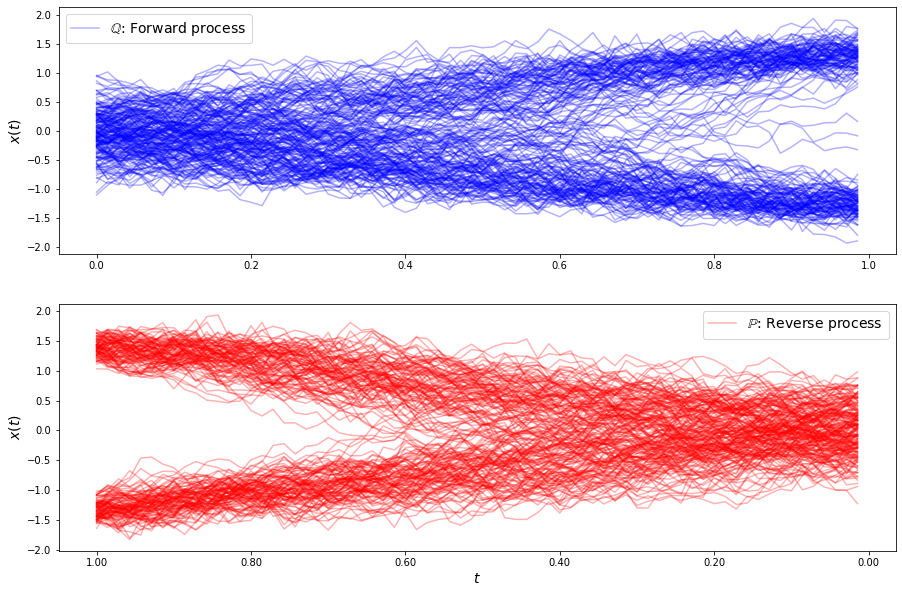

In [11]:
t, Xts = solve_sde_RK(alfa=drift_q, beta=1, X0=X1,dt=dt, N=int(1/dt)+1)
t_, Xts_ = solve_sde_RK(alfa=drift_p, beta=1, X0=X2,dt=dt, N=int(1/dt)+1)

plot_trajectories_both(Xts, t, Xts_, t_)

In [12]:
import scipy.stats as st

print(st.ks_2samp(Xts[:,-1,:-1].flatten().detach().cpu().numpy(), X2.flatten().detach().cpu().numpy()))
print(st.ks_2samp(Xts_[:,-1,:-1].flatten().detach().cpu().numpy(), X1.flatten().detach().cpu().numpy()))

Ks_2sampResult(statistic=0.125, pvalue=0.0878382826713132)
Ks_2sampResult(statistic=0.11, pvalue=0.17793352788293415)


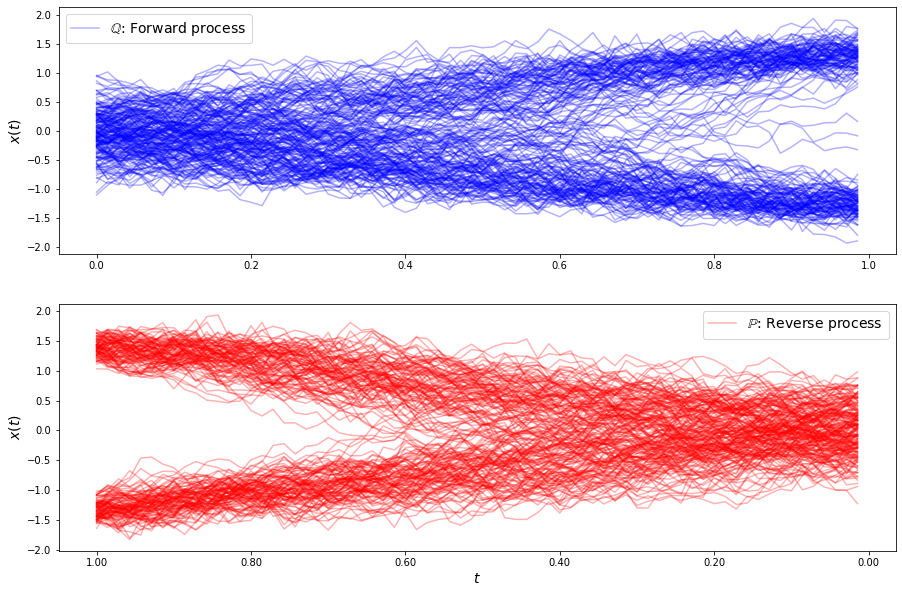

In [14]:
plot_trajectories_both(Xts, t, Xts_, t_, name="gp_final_bimodal_trajectories.png")

In [ ]:
t

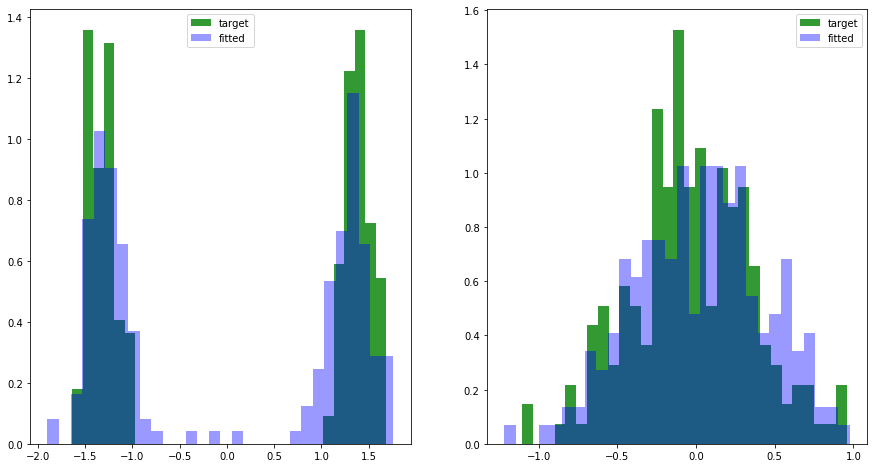

In [13]:
fig, axs = plt.subplots(1,2, figsize=(15, 8))


bins = 30
axs[1].hist(( X1.detach().cpu().numpy().flatten()), alpha=0.8, bins=bins, label="target", density=True, color="green");
axs[1].hist(( Xts_[:,-1,:-1].flatten().detach().cpu().numpy()), alpha=0.4, bins=bins, label="fitted", density=True, color="blue");



xx = torch.linspace(float(min(X1.min().detach().cpu().numpy(), Xts_[:,-1,:-1].min().detach().cpu().numpy() )) -3 ,
                    float(max(X1.max().detach().cpu().numpy(), Xts_[:,-1,:-1].max().detach().cpu().numpy() ))+3).reshape(-1,1).cuda().double()



# xx = torch.linspace(-10, 10).reshape(-1,1).cuda().double()
xx = torch.linspace(float(min(X2.min().detach().cpu().numpy(), Xts[:,-1,:-1].min().detach().cpu().numpy() )) -3 ,
                    float(max(X2.max().detach().cpu().numpy(), Xts[:,-1,:-1].max().detach().cpu().numpy() ))+3).reshape(-1,1).cuda().double()



# bins = 9
axs[0].hist(( X2.detach().cpu().numpy().flatten()), alpha=0.8, bins=bins, label="target", density=True, color="green");
axs[0].hist(( Xts[:,-1,:-1].flatten().detach().cpu().numpy()), alpha=0.4, bins=bins, label="fitted", density=True, color="blue");
axs[0].legend()
axs[1].legend()
plt.savefig("gp_2_mode_final_boundaires.png")